In [52]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
from plotly.graph_objs import *
from ggplot import *
from collections import Counter

project_id = "the-d-team-164512"
init_notebook_mode(connected=True)

## To Do
1. Select aggregation lvl (for diabetes probably per patient and year)
2. Manufacture features needed for the models (e.g. avg money spent for drugs or is_taking_drug for 5 most popular drugs among diabetic that are not popular in other groups). Normalize the features to have 0 mean and stdev 1.
3. Write validation function according to the metric used in leaderboard (AUC, see questions) to use in checking how well the model is doing.
4. Create classification of patients using diabetes drugs (1 - if used in a year, 0 if not). Final prediction is about patients in 2016, however we can also use previous years to have more models and ensemble them later.
5. Create logistic regression model to classify based on previous year input whether the patient will develop diabetes next year. The last layer should not omit the step of choosing as 1 the class with higher probability, instead it should return the probability of diabetes class itself.
6. Create another model that uses the whole history to predict 2016.
7. Use the same approach to create random forest model.
8. Create a few layers deep (4?/5?) fully connected NN with dropout layers and l2 regularization. Remember about correct initializing (std = 2/sqrt(n), n  - number of neurons
9. Create RNN(LSTM) with yearly inputs (?)
10. Make an ensemble of created models.
11. Additional models? - xgboost

 
I thought also about testing a bit more regarding store profitability and how it's influenced by main drugs sold. I thought about dividing the stores into few classes (negative, below 5k, 5k-40k, 40k-100k, 100k-200k, above) and checking the differences between them. Visualizations to present in the report + some models based on that. 

Proposed features:
* for top 5 popular medications - transpose to columns % of all transactions in the store per store
* top 5 manufacturers sold there - transposed
* what percent of patients have chronic disease - transposed
* ethical subcategory - t
* atc_lvl1_code - t


## Questions
1. How to treat patients that were taking diabetes meds before 2016 and later stopped (according to the dataset). Is it possible that their diabetes transactions have been held out? This is important, since we will use them as ground truth to train our classifier.
2. The whole idea of submitting probabilities instead of classes seems weird. Are the results that those will be compared against not classes? The held out set should contain classfication based on ground truth, so it should know whether a patient used diabetes drug or not. Are the probabilities transformed then into classes? I will check what exactly is the lost function. http://tiberius.biz/ausdm09/index.html#4 Seems like they measure the area under the curve obtained by plotting the cumulative % of proper classification against the misclassification (in a sense). I'm not sure though how this would produce the results shown on the leaderboard, they look more like precision (?), though this would be a bad metric for the competition :D

In [ ]:
query = """#standardSQL

select store_id, dispense_year, drug_id, count(1) as cnt
from dthon.transactions_enriched te
where drug_id in (6470,5884,8208,2117,6031,12637)
group by store_id, dispense_year, drug_id
"""

PARTITION OVER
new row as a a sum
divide existing by the sum
average over store type (or store type and year)
plot - violin (then violin normalized, so that each group is in the same scale) - divide for all drug groups by average from the first drug)

same procedure for atc, chronic illness, man group, ethical .
Maybe: Check scatter plot - profitability overall vs differnce against chemist price

All those columns can be used in a model for profitability prediction + state + 


In [100]:
amount = 6

var = "CAT_atc1code"

query_1 = """
select """ + var + """, COUNT(1) as cnt
from dthon.transactions_enriched te
group by """ + var +"""
order by cnt desc
limit """ + str(amount)

data = pd.read_gbq(query_1, project_id,dialect='standard')

data.iloc[:,0]
len(data.iloc[:,0])

names = [str(obj) for obj in data.iloc[:,0]]
names2 = "', '".join(names)
names2 = "'" + names2 + "'"
names2

x=''
for name in names:
    x = x + "SUM(IF("+ var +" = '" + name + "', cnt, 0)) as cnt_" + name + """,
"""


query_old = """
SELECT sc.*, syp.CAT_profit_group from
(SELECT store_id, dispense_year, 
SUM(IF(drug_id = 6470, cnt, 0)) as cnt6470,
SUM(IF(drug_id = 5884, cnt, 0)) as cnt5884,
SUM(IF(drug_id = 8208, cnt, 0)) as cnt8208,
SUM(IF(drug_id = 2117, cnt, 0)) as cnt2117,
SUM(IF(drug_id = 6031, cnt, 0)) as cnt6031,
SUM(IF(drug_id = 12637, cnt, 0)) as cnt12637,
SUM(cnt) as cnt
FROM (select store_id, dispense_year, drug_id, count(1) as cnt
from dthon.transactions_enriched te
where drug_id in (6470,5884,8208,2117,6031,12637)
group by store_id, dispense_year, drug_id)
group by 1, 2) sc
left join dthon.store_year_profit syp
on syp.store_id = sc.store_id
and syp.dispense_year = sc.dispense_year
and sc.cnt != 0
"""


query = """
SELECT sc.*, syp.CAT_profit_group from
(SELECT store_id, dispense_year, 
""" + x + """
SUM(IF(""" + var + """ = "other", cnt, 0)) as other,
SUM(cnt) as cnt
FROM (select store_id, dispense_year, cast(""" + var + """ as string) as """ + var + """, count(1) as cnt
from dthon.transactions_enriched te
where """ + var + """ in (""" + names2 + """)
group by store_id, dispense_year, """ + var + """
union all
select store_id, dispense_year, "other" as """ + var + """, count(1) as cnt
from dthon.transactions_enriched te
where """ + var + """ not in (""" + names2 + """)
group by store_id, dispense_year)
group by 1, 2 
)
sc
left join dthon.store_year_profit syp
on syp.store_id = sc.store_id
and syp.dispense_year = sc.dispense_year
and sc.cnt != 0
"""

data = pd.read_gbq(query, project_id,dialect='standard')

Requesting query... ok.
Query running...
Query done.
Cache hit.

Retrieving results...
Got 6 rows.

Total time taken 2.06 s.
Finished at 2017-05-03 12:26:10.
Requesting query... ok.
Query running...
Query done.
Processed: 1.1 Gb

Retrieving results...
  Got page: 1; 100% done. Elapsed 12.86 s.
Got 17068 rows.

Total time taken 13.15 s.
Finished at 2017-05-03 12:26:24.


In [105]:
data.head(n=10)

,store_id,dispense_year,cnt_C,cnt_N,cnt_A,cnt_R,cnt_B,cnt_M,other,cnt,CAT_profit_group
0,579,2010,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1,1.0
1,2327,2010,0.500000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,2,1.0
2,897,2010,0.111111,0.444444,0.333333,0.111111,0.000000,0.000000,0.000000,9,1.0
3,211,2010,0.428571,0.142857,0.142857,0.142857,0.000000,0.142857,0.000000,7,1.0
4,1564,2010,0.090909,0.454545,0.272727,0.000000,0.000000,0.090909,0.090909,11,1.0
5,2603,2011,0.454545,0.227273,0.212121,0.015152,0.000000,0.000000,0.090909,66,NaN
6,1471,2011,0.778947,0.073684,0.126316,0.000000,0.000000,0.000000,0.021053,95,1.0
7,27,2011,0.608003,0.084479,0.193465,0.015303,0.034226,0.026471,0.038052,9671,3.0
8,665,2011,0.169492,0.559322,0.203390,0.000000,0.000000,0.016949,0.050847,59,1.0
9,1546,2011,0.450382,0.300254,0.134860,0.017812,0.030534,0.005089,0.061069,393,1.0


In [97]:

print(x)

SUM(IF(drug_id = 'C', cnt, 0)) as cnt_C,
SUM(IF(drug_id = 'N', cnt, 0)) as cnt_N,
SUM(IF(drug_id = 'A', cnt, 0)) as cnt_A,
SUM(IF(drug_id = 'R', cnt, 0)) as cnt_R,
SUM(IF(drug_id = 'B', cnt, 0)) as cnt_B,
SUM(IF(drug_id = 'M', cnt, 0)) as cnt_M,



In [101]:
val = 2 + amount + 1

data.iloc[:,2:val] = data.iloc[:,2:val].divide(data.iloc[:,val], axis = 0)

In [106]:
a = [list(data.columns)[i] for i in [1,val+1]+ list(range(2,val))]
grp = data.groupby(by = [list(data.columns)[i] for i in [1,val+1]])[a]

In [107]:
summ = grp.mean()
plt_dat = pd.melt(summ, id_vars = [list(data.columns)[i] for i in [1,val+1]], 
                    value_vars = [list(data.columns)[i] for i in list(range(2,val))])

In [108]:
plt_dat

,dispense_year,CAT_profit_group,variable,value
0,2008,1.0,cnt_C,0.083333
1,2009,1.0,cnt_C,0.500000
2,2010,0.0,cnt_C,0.000000
3,2010,1.0,cnt_C,0.487135
4,2011,0.0,cnt_C,0.268886
5,2011,1.0,cnt_C,0.413947
6,2011,2.0,cnt_C,0.493261
7,2011,3.0,cnt_C,0.516124
8,2011,4.0,cnt_C,0.518297
9,2011,5.0,cnt_C,0.470041


In [109]:
#sns.violinplot(summ[''])
final = plt_dat.groupby(by = [list(plt_dat.columns)[i] for i in [1,2]]).value.mean()
fig = plt.figure()
final.unstack().plot(kind="bar",stacked=True, grid = False)

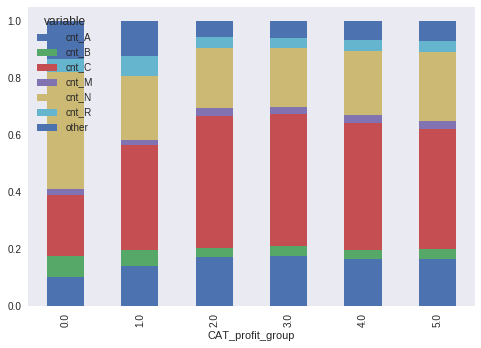

In [110]:
plt.show()